<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S11/S11_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U albumentations
%pip install -U torch_lr_finder
%pip install -q torchview
%pip install -q -U graphviz
%pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=b2aa058ae7a6106fddb0b759d719af2b03b201a025681d54452cc5b8f528d54a
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/ERAV1/S11/

/content/gdrive/My Drive/Colab Notebooks/ERAV1/S11


In [4]:
!ls -l

total 2035
drwx------ 2 root root    4096 Aug 12 13:10 data
-rw------- 1 root root    2279 Aug 12 12:57 data_aug.py
-rw------- 1 root root    1229 Aug  4 09:39 data_loaders.py
drwx------ 2 root root    4096 Aug 12 13:05 models
drwx------ 2 root root    4096 Aug 12 13:10 __pycache__
-rw------- 1 root root  809053 Aug 12 15:18 S11_practice2.ipynb
-rw------- 1 root root  167504 Aug 12 13:03 S11_practice2_local.ipynb
-rw------- 1 root root 1069149 Aug  2 09:21 S11_rohan.ipynb
-rw------- 1 root root    1461 Aug 11 09:58 temp.py
-rw------- 1 root root    2458 Aug  4 13:09 train_test.py
-rw------- 1 root root    7279 Aug  7 09:33 utils.py
-rw------- 1 root root    7727 Aug 12 15:16 utils_visualization.py


In [11]:
%matplotlib inline

import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data_loaders import train_loader, test_loader
# from utils_visualization import visualize_data_loader, wrong_and_correct_classified_data, plot_with_actual_predicted_class, get_random_index
from utils_visualization import visualize_data_samples, wrong_and_correct_classified_data, plot_with_actual_predicted_class, get_random_index, display_gradcam_output
# from custom_resnet import Net
from models.resnet import *
from train_test import train, test



import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

means=[0.485,0.456,0.406]
stds=[0.229,0.224,0.225]

inv_means=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
inv_stds=[1/0.229, 1/0.224, 1/0.225]

batch_size = 512
num_workers = 2
cuda_available = torch.cuda.is_available()
cuda_available

CUDA Available? True


True

In [7]:
trainldr = train_loader(batch_size, num_workers, cuda_available, means, stds)
testldr = test_loader(batch_size, num_workers, cuda_available, means, stds)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([512, 3, 32, 32]) <class 'torch.Tensor'>


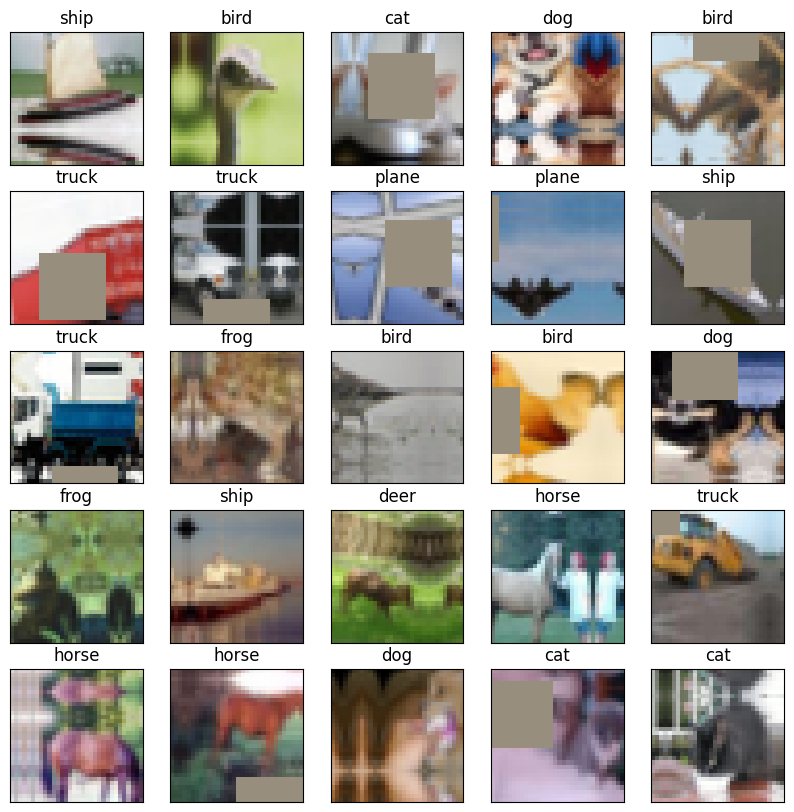

In [8]:
# import math


dataiter = iter(trainldr)
image_tensors, labels = next(dataiter)
print(image_tensors.shape, type(image_tensors))


# visualize_data_loader(images, labels, classes, 5)

number_of_samples = 25


visualize_data_samples(image_tensors, labels, classes, number_of_samples, inv_means, inv_stds)

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.22E-02


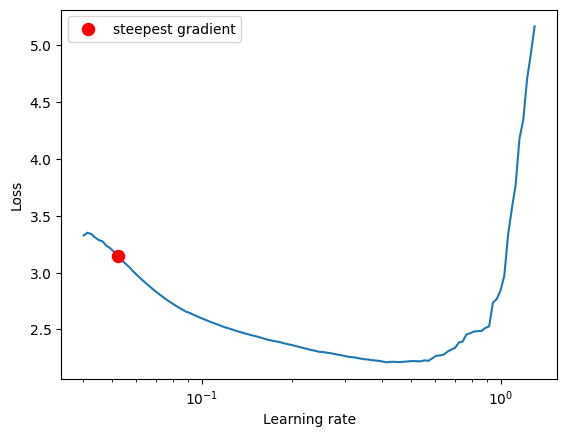

In [10]:
import torch.nn as nn
from torch_lr_finder import LRFinder
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')
# train_criterion = F.nll_loss
# test_criterion = F.nll_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, train_criterion, device='cuda')
lr_finder.range_test(trainldr,end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [12]:
import torch
from tqdm import tqdm
from torch.optim import lr_scheduler

EPOCHS = 20

model =  ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=5.22E-02,
                                    steps_per_epoch=len(trainldr),
                                    epochs=EPOCHS,
                                    # pct_start=5/EPOCHS,
                                    pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                    div_factor=100,
                                    final_div_factor=100,
                                    three_phase=False,
                                    anneal_strategy='linear')


train_losses = []
test_losses = []
train_acc = []
test_acc = []



# learning_rate = []
# EPOCHS = 20
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_losses, train_acc = train(model, device, trainldr, optimizer, epoch, scheduler, train_criterion, train_losses, train_acc)
    test_loss, test_acc = test(model, device, testldr,test_criterion, test_losses, test_acc)
print('Finished Training')



lr=  0.000522


Epoch=1 Loss=1.6114585399627686 Batch_id=97 Accuracy=34.70: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 1.7408, Accuracy: 4183/10000 (41.83%)

lr=  0.009149672913117546


Epoch=2 Loss=1.4076814651489258 Batch_id=97 Accuracy=45.40: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 1.4851, Accuracy: 4881/10000 (48.81%)

lr=  0.017777345826235094


Epoch=3 Loss=1.4079077243804932 Batch_id=97 Accuracy=52.75: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 1.8146, Accuracy: 4477/10000 (44.77%)

lr=  0.02640501873935264


Epoch=4 Loss=0.9798606038093567 Batch_id=97 Accuracy=58.11: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 1.5923, Accuracy: 5147/10000 (51.47%)

lr=  0.03503269165247019


Epoch=5 Loss=1.0451549291610718 Batch_id=97 Accuracy=61.29: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 1.8167, Accuracy: 5058/10000 (50.58%)

lr=  0.043660364565587736


Epoch=6 Loss=1.0466821193695068 Batch_id=97 Accuracy=64.43: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 1.2101, Accuracy: 6299/10000 (62.99%)

lr=  0.05216195715743441


Epoch=7 Loss=0.9099739789962769 Batch_id=97 Accuracy=67.83: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.8796, Accuracy: 7004/10000 (70.04%)

lr=  0.048433758586005835


Epoch=8 Loss=0.7489835619926453 Batch_id=97 Accuracy=71.61: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.7332, Accuracy: 7608/10000 (76.08%)

lr=  0.04470556001457726


Epoch=9 Loss=0.8080465197563171 Batch_id=97 Accuracy=73.88: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.7060, Accuracy: 7589/10000 (75.89%)

lr=  0.04097736144314869


Epoch=10 Loss=0.6890819072723389 Batch_id=97 Accuracy=75.43: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 0.6355, Accuracy: 7901/10000 (79.01%)

lr=  0.037249162871720115


Epoch=11 Loss=0.6856144666671753 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.6149, Accuracy: 7893/10000 (78.93%)

lr=  0.03352096430029155


Epoch=12 Loss=0.6198899149894714 Batch_id=97 Accuracy=79.09: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.4980, Accuracy: 8301/10000 (83.01%)

lr=  0.029792765728862976


Epoch=13 Loss=0.5165726542472839 Batch_id=97 Accuracy=80.31: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.5039, Accuracy: 8353/10000 (83.53%)

lr=  0.026064567157434403


Epoch=14 Loss=0.4894197881221771 Batch_id=97 Accuracy=81.57: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.4118, Accuracy: 8620/10000 (86.20%)

lr=  0.022336368586005833


Epoch=15 Loss=0.5067570805549622 Batch_id=97 Accuracy=82.95: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.3453, Accuracy: 8846/10000 (88.46%)

lr=  0.018608170014577263


Epoch=16 Loss=0.47367995977401733 Batch_id=97 Accuracy=83.92: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.3249, Accuracy: 8897/10000 (88.97%)

lr=  0.01487997144314869


Epoch=17 Loss=0.39824503660202026 Batch_id=97 Accuracy=84.87: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.3215, Accuracy: 8921/10000 (89.21%)

lr=  0.011151772871720117


Epoch=18 Loss=0.3808738589286804 Batch_id=97 Accuracy=86.08: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.2878, Accuracy: 9040/10000 (90.40%)

lr=  0.007423574300291544


Epoch=19 Loss=0.3697373867034912 Batch_id=97 Accuracy=87.05: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.2599, Accuracy: 9133/10000 (91.33%)

lr=  0.0036953757288629777


Epoch=20 Loss=0.3735744059085846 Batch_id=97 Accuracy=88.09: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.2487, Accuracy: 9163/10000 (91.63%)

Finished Training


In [13]:
# dataiter = iter(testldr)
# images, labels = next(dataiter)


# visualize_data_loader(images, labels, classes, 5)

In [14]:


correct_preds,correct_target,correct_img_data, incorrect_preds,incorrect_target,incorrect_img_data = wrong_and_correct_classified_data(model, testldr, device, classes)

correct_idxs = get_random_index(correct_img_data)
incorrect_idxs = get_random_index(incorrect_img_data)

In [15]:
# type(correct_img_data),len(correct_img_data), type(correct_preds),len(correct_preds), correct_preds.shape

correct_idxs, incorrect_idxs

(array([7092, 7886, 4338, 3336, 3451, 7713, 4471, 3637, 5396, 7306, 5941,
        4875, 2750, 4024, 2843, 8261, 3551,  338, 8996, 7659, 8904, 3594,
        1505, 5018,  327]),
 array([247, 309, 280, 505, 226, 542, 324, 437, 447, 472, 620, 225, 799,
        576, 572, 516, 831, 107, 152,  73, 293, 145, 570, 282, 340]))

In [16]:
# import random
# # random_idxs = random.sample(range(0, len(correct_preds)), 10)
# # random_idxs


# correct_preds1 = [x[0] for x in correct_preds]
# correct_target1 = [x[0] for x in correct_target]

# incorrect_preds1 = [x[0] for x in incorrect_preds]
# incorrect_target1 = [x[0] for x in incorrect_target]

# incorrect_preds,incorrect_target,incorrect_img_data





# num_list = [10, 15, 20, 25, 30]
# random_index = random.randint(0, len(correct_preds) - 1)
# random_element = my_list[random_index]
# print('Random Number:', random_element)


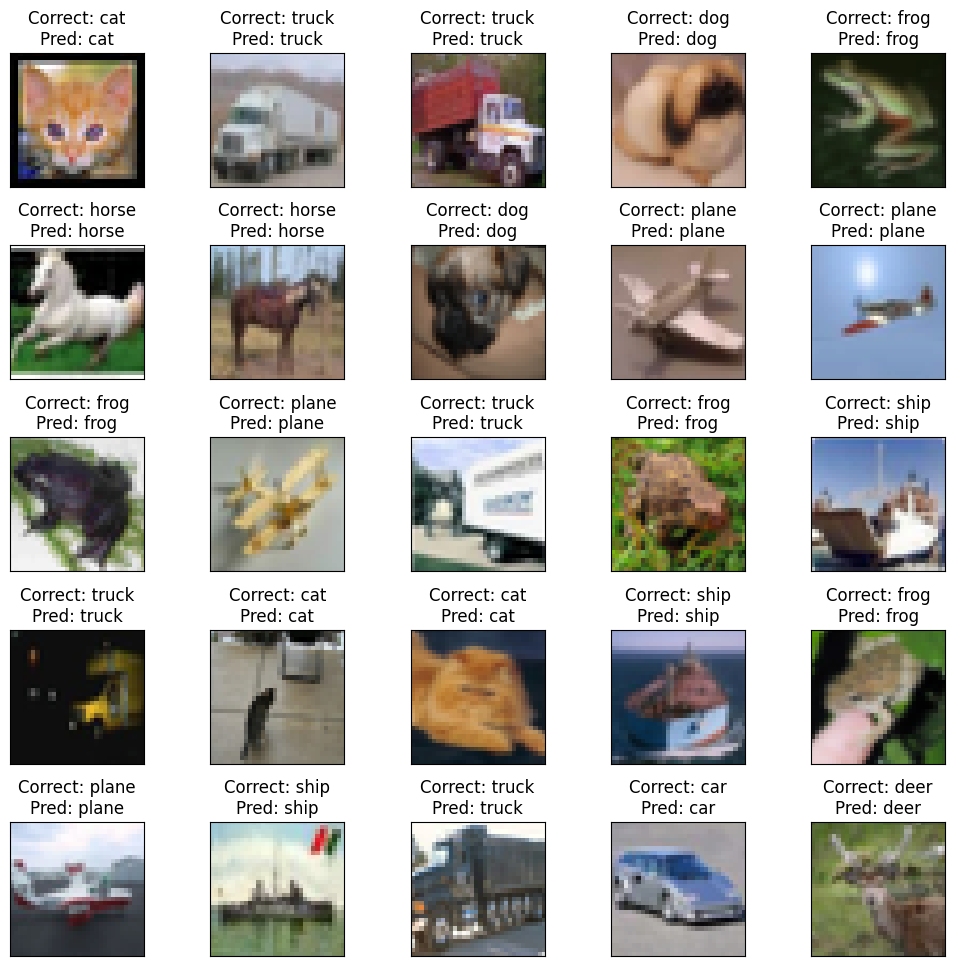

In [18]:
# trgt, imgs, prds = plot_with_actual_predicted_class(correct_target, correct_img_data, correct_preds,correct_idxs, classes)

trgt, imgs, prds = plot_with_actual_predicted_class(correct_target, correct_img_data, correct_preds,correct_idxs, classes,number_of_samples, inv_means,inv_stds)


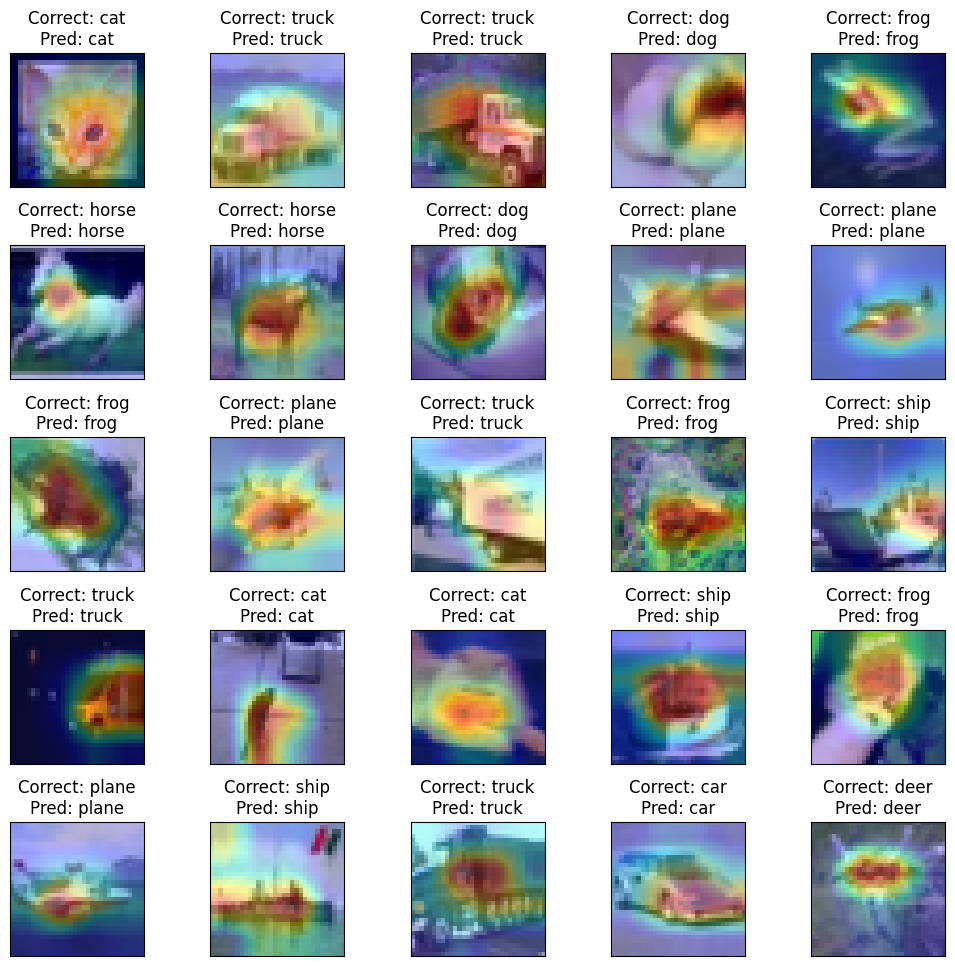

In [19]:
target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None
display_gradcam_output(imgs, trgt.squeeze(), prds.squeeze(), classes, model, inv_means, inv_stds, target_layers, targets, number_of_samples, transparency=0.70)

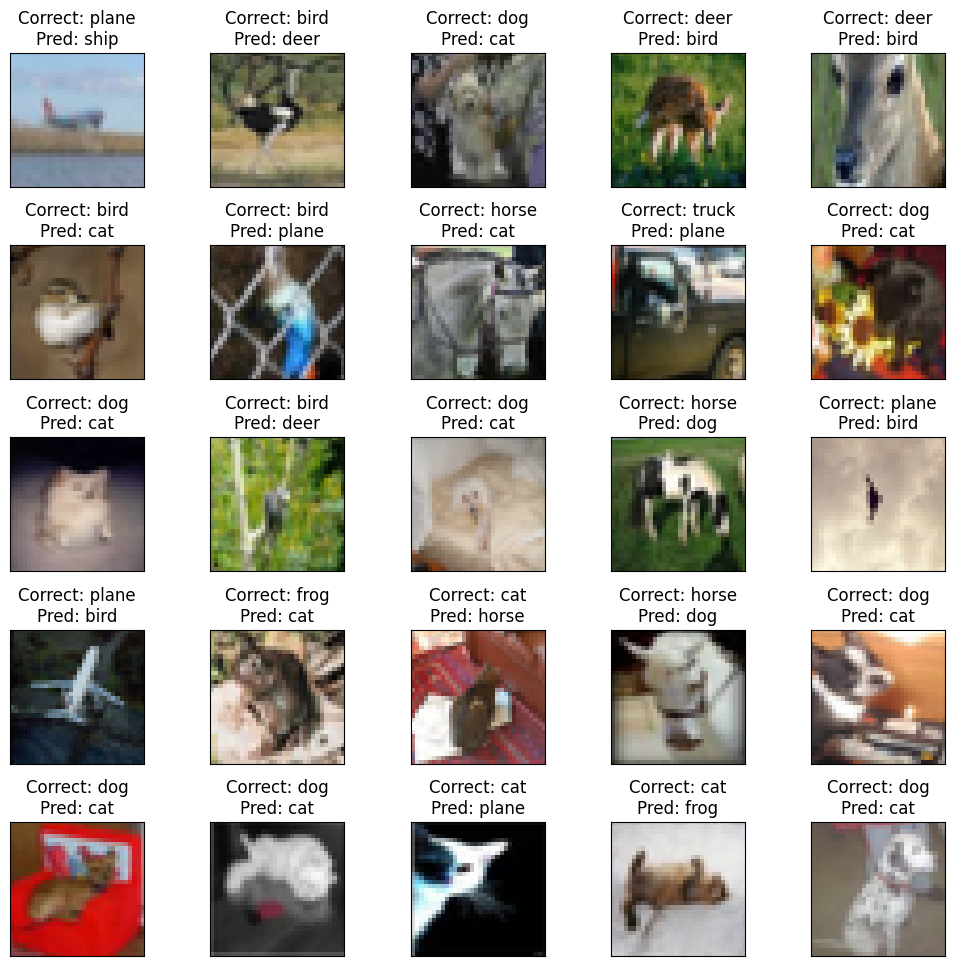

In [20]:
trgt, imgs, prds = plot_with_actual_predicted_class(incorrect_target, incorrect_img_data, incorrect_preds,incorrect_idxs,classes,number_of_samples, inv_means,inv_stds)


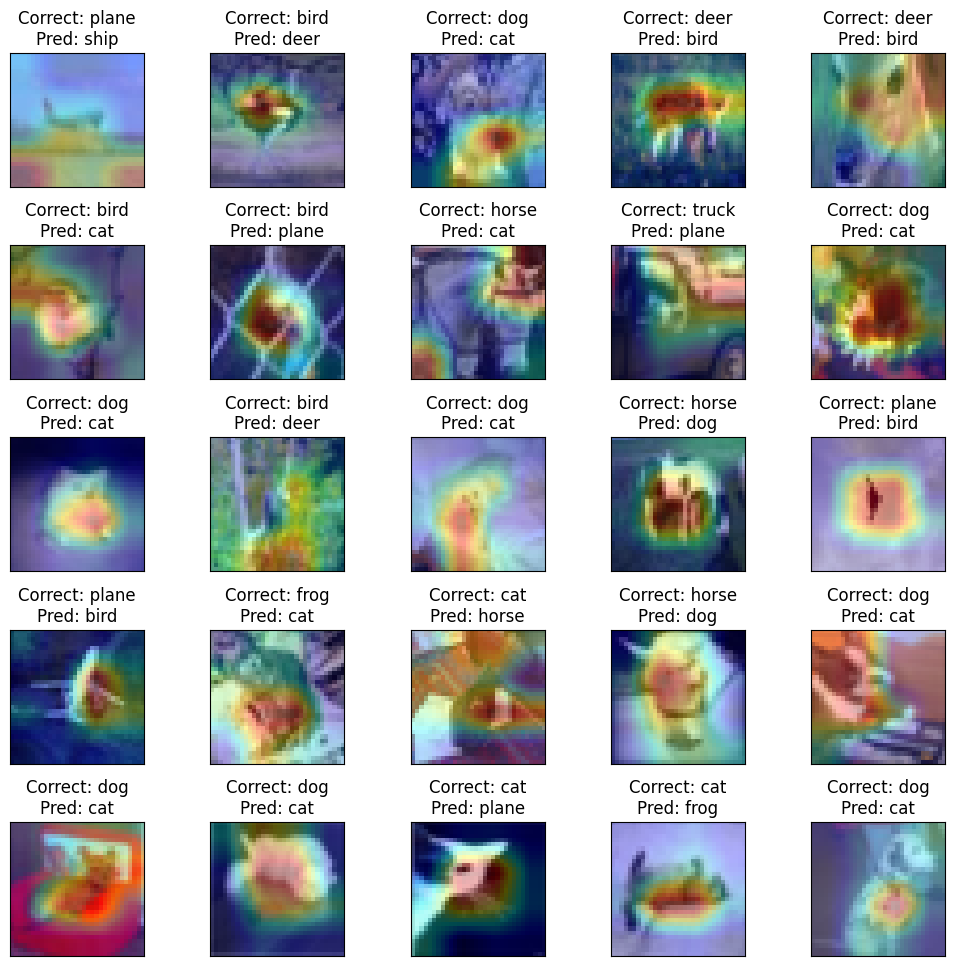

In [23]:

target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None
display_gradcam_output(imgs, trgt.squeeze(), prds.squeeze(), classes, model, inv_means, inv_stds, target_layers, targets, number_of_samples, transparency=0.70)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [24]:
# ! pip install -q torchview
# ! pip install -q -U graphviz

In [25]:

from torchview import draw_graph
# from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

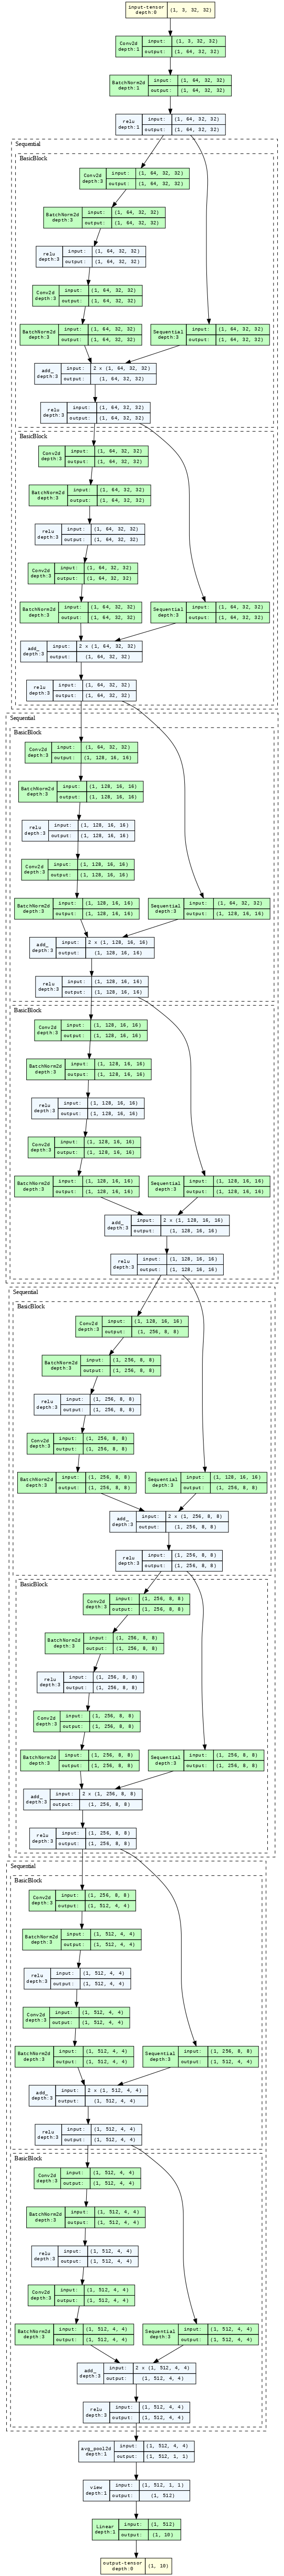

In [26]:
from torchview import draw_graph
# model = Net()
# batch_size = 2
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(3, 32, 32), device='meta')
model_graph1 = draw_graph(ResNet18(), input_size=(1,3,32,32), expand_nested=True, graph_dir = 'TB')
model_graph1.visual_graph